#Dependencies

In [ ]:
!pip install --upgrade tensorflow_federated

In [ ]:
!pip install keras_self_attention

In [ ]:
!pip install keras==2.4.3

In [ ]:
!pip install nest_asyncio

#Imports

In [ ]:
import tensorflow
from tensorflow import keras
import tensorflow_federated
import keras_self_attention

print(tensorflow.__version__)
print(keras.__version__)
print(tensorflow_federated.__version__)
print(keras_self_attention.__version__)

2.5.2
2.5.0
0.19.0
0.50.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import keras
from keras_self_attention import SeqSelfAttention as Attention
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from tensorflow.keras import applications
from tensorflow.keras.layers import InputLayer, Dropout, Bidirectional, Masking, LSTM, Dense, Activation, Flatten, Input, concatenate, Embedding
from tensorflow.keras import backend as K 
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model, Sequential
from collections import OrderedDict
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import matplotlib.pyplot as plt

# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.optimizers import SGD
#from mpl_toolkits.mplot3d import Axes3D
# from IPython.display import SVG

#Loading Data

In [ ]:
bd = np.load("/content/drive/MyDrive/dataset/body.npy")
rh = np.load("/content/drive/MyDrive/dataset/right_hand.npy")
lh = np.load("/content/drive/MyDrive/dataset/left_hand.npy")
rf = np.load("/content/drive/MyDrive/dataset/right_foot.npy")
lf = np.load("/content/drive/MyDrive/dataset/left_foot.npy")

label = np.load("/content/drive/MyDrive/dataset/label60.npy")

In [ ]:
# We have to decrease the number of data to deal with memory problem
bd = bd[:1000,:,:]
rh = rh[:1000,:,:]
lh = lh[:1000,:,:]
rf = rf[:1000,:,:]
lf = lf[:1000,:,:]

label = label[:1000]
cat_target = to_categorical(label)
cat_target = np.delete(cat_target, 0, 1)

In [ ]:
print(bd.shape)
print(rh.shape)
print(lh.shape)
print(rf.shape)
print(lf.shape)
print(cat_target.shape)
print(label[5])
print(cat_target[5])

(1000, 300, 15)
(1000, 300, 18)
(1000, 300, 18)
(1000, 300, 12)
(1000, 300, 12)
(1000, 60)
6.0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#Variables

In [ ]:
number_of_clients = 4
shuffle_ = 2
batch_ = 2
epochs = 4
round_numbers = 6

#Data split

In [ ]:
data_per_client = int(bd.shape[0] / (number_of_clients + 1))    

bd_client_1 = bd[:data_per_client , : , :]
rh_client_1 = rh[:data_per_client , : , :]
lh_client_1 = lh[:data_per_client , : , :]
rf_client_1 = rf[:data_per_client , : , :]
lf_client_1 = lf[:data_per_client , : , :]
label_client_1 = cat_target[:data_per_client]

bd_client_2 = bd[data_per_client:2*data_per_client , : , :]
rh_client_2 = rh[data_per_client:2*data_per_client , : , :]
lh_client_2 = lh[data_per_client:2*data_per_client , : , :]
rf_client_2 = rf[data_per_client:2*data_per_client , : , :]
lf_client_2 = lf[data_per_client:2*data_per_client , : , :]
label_client_2 = cat_target[data_per_client:2*data_per_client]

bd_client_3 = bd[2*data_per_client:3*data_per_client , : , :]
rh_client_3 = rh[2*data_per_client:3*data_per_client , : , :]
lh_client_3 = lh[2*data_per_client:3*data_per_client , : , :]
rf_client_3 = rf[2*data_per_client:3*data_per_client , : , :]
lf_client_3 = lf[2*data_per_client:3*data_per_client , : , :]
label_client_3 = cat_target[2*data_per_client:3*data_per_client]

bd_client_4 = bd[3*data_per_client:4*data_per_client , : , :]
rh_client_4 = rh[3*data_per_client:4*data_per_client , : , :]
lh_client_4 = lh[3*data_per_client:4*data_per_client , : , :]
rf_client_4 = rf[3*data_per_client:4*data_per_client , : , :]
lf_client_4 = lf[3*data_per_client:4*data_per_client , : , :]
label_client_4 = cat_target[3*data_per_client:4*data_per_client]

bd_test = bd[4*data_per_client:, : , :]
rh_test = rh[4*data_per_client:, : , :]
lh_test = lh[4*data_per_client:, : , :]
rf_test = rf[4*data_per_client:, : , :]
lf_test = lf[4*data_per_client:, : , :]
label_test = cat_target[4*data_per_client:]

In [ ]:
def create_federated_data(in1, in2, in3, in4, in5, label):

  x_train_client_1 = OrderedDict(
    x=OrderedDict(
      input_1 = in1,
      input_2 = in2,
      input_3 = in3,
      input_4 = in4,
      input_5 = in5),
    y = label)

  dataset = tf.data.Dataset.from_tensor_slices(x_train_client_1)
  batch = dataset.shuffle(shuffle_).batch(batch_)

  return batch

In [ ]:
fed_client_1 = [create_federated_data(bd_client_1, rh_client_1, lh_client_1, rf_client_1, lf_client_1, label_client_1) for epoch in range(epochs)]
fed_client_2 = [create_federated_data(bd_client_2, rh_client_2, lh_client_2, rf_client_2, lf_client_2, label_client_2) for epoch in range(epochs)]
fed_client_3 = [create_federated_data(bd_client_3, rh_client_3, lh_client_3, rf_client_3, lf_client_3, label_client_3) for epoch in range(epochs)]
fed_client_4 = [create_federated_data(bd_client_4, rh_client_4, lh_client_4, rf_client_4, lf_client_4, label_client_4) for epoch in range(epochs)]
fed_test = [create_federated_data(bd_test, rh_test, lh_test, rf_test, lf_test, label_test) for epoch in range(epochs)]

#Model Architecture

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 15)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300, 18)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 18)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300, 12)]    0                                            
______________________________________________________________________________________________

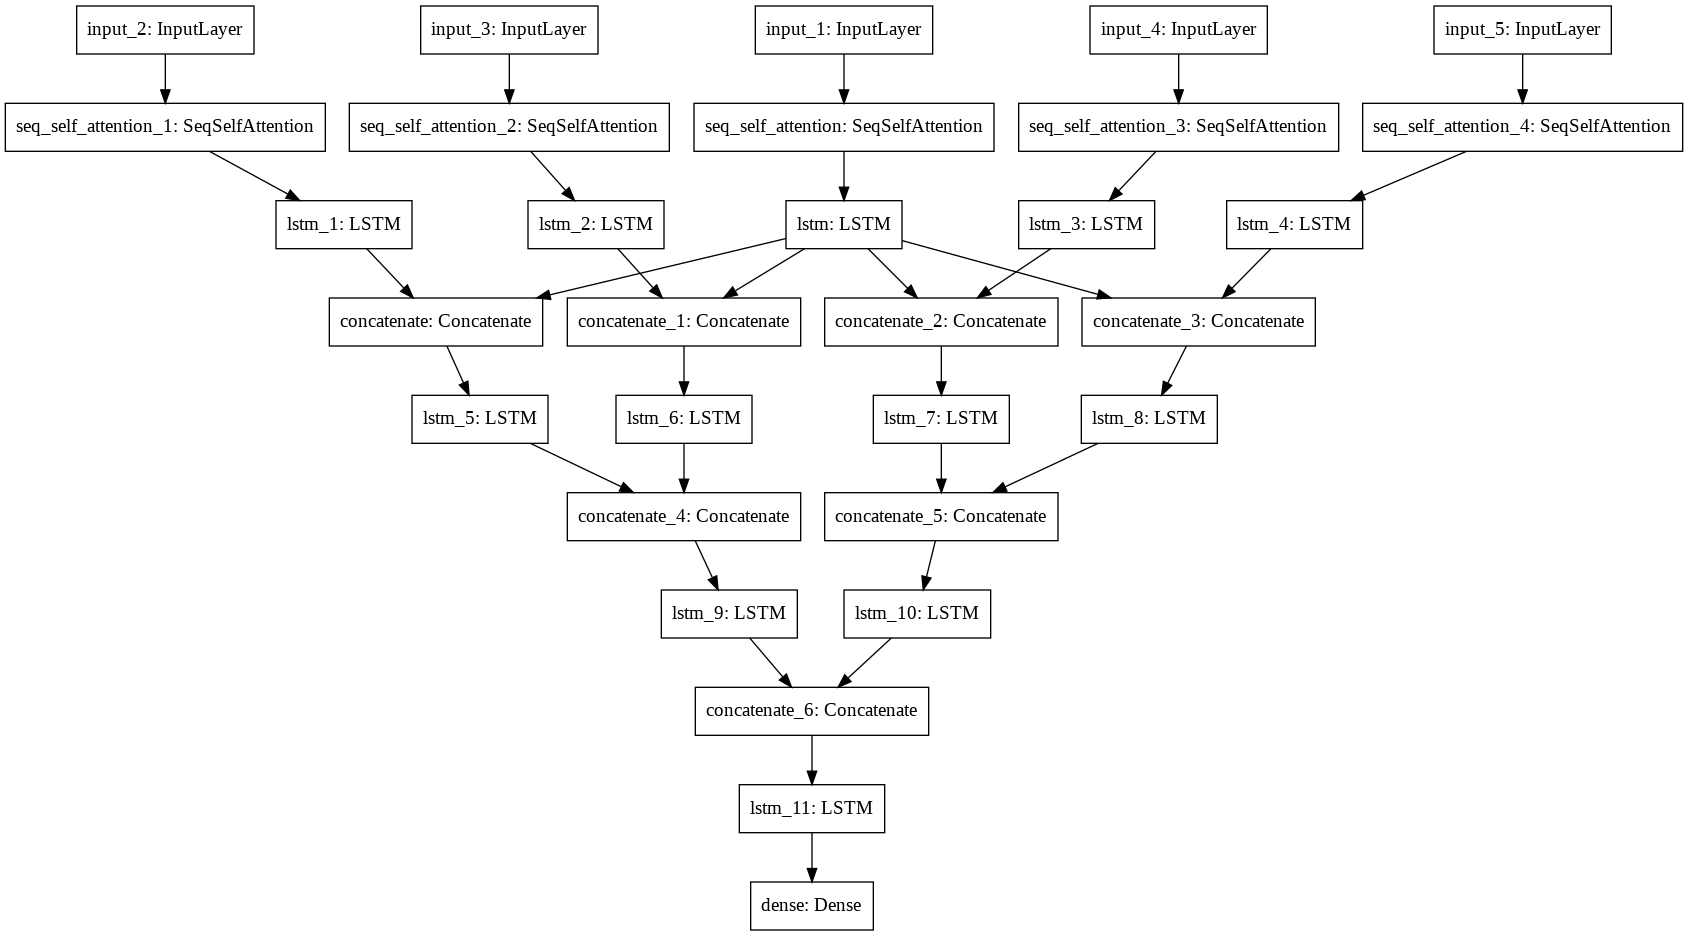

In [ ]:
def create_keras_model():

  bdbd = Input(shape=(300,15))
  bd1  = Attention()(bdbd) 
  bd1  = LSTM(32, activation='tanh', return_sequences=True)(bd1)

  rhrh = Input(shape=(300,18))
  rh1  = Attention()(rhrh) 
  rh1  = LSTM(32, activation='tanh', return_sequences=True)(rh1)

  lhlh = Input(shape=(300,18))
  lh1  = Attention()(lhlh) 
  lh1  = LSTM(32, activation='tanh', return_sequences=True)(lh1)

  rfrf = Input(shape=(300,12))
  rf1  = Attention()(rfrf) 
  rf1  = LSTM(32, activation='tanh', return_sequences=True)(rf1)

  lflf = Input(shape=(300,12))
  lf1  = Attention()(lflf) 
  lf1  = LSTM(32, activation='tanh', return_sequences=True)(lf1)


  bdrh  = concatenate([bd1, rh1],axis=-1)
  bdrh1 = LSTM(32, activation='tanh', return_sequences=True)(bdrh)

  bdlh  = concatenate([bd1, lh1],axis=-1)
  bdlh1 = LSTM(32, activation='tanh', return_sequences=True)(bdlh)

  bdrf  = concatenate([bd1, rf1],axis=-1)
  bdrf1 = LSTM(32, activation='tanh', return_sequences=True)(bdrf)

  bdlf  = concatenate([bd1, lf1],axis=-1)
  bdlf1 = LSTM(32, activation='tanh', return_sequences=True)(bdlf)


  upbody  = concatenate([bdrh1, bdlh1],axis=-1)
  upbody1 = LSTM(32, activation='tanh', return_sequences=True)(upbody)

  downbody  = concatenate([bdrf1, bdlf1],axis=-1)
  downbody1 = LSTM(32, activation='tanh', return_sequences=True)(downbody)

  body  = concatenate([upbody1, downbody1],axis=-1)
  body1 = LSTM(8, activation='tanh')(body)

  out = Dense(10, activation='softmax')(body1)#10->60

  model = Model([bdbd, rhrh, lhlh, rfrf, lflf], out)

  return model

model=create_keras_model()
model.summary()
plot_model(model, to_file='hierarchy-model.png')

#Federated Model

In [ ]:
def create_federated_model():

    keras_model = create_keras_model()

    input_spec = OrderedDict(
      x=OrderedDict(
          input_1=tf.TensorSpec(shape=[None, 300, 15], dtype=np.float32),
          input_2=tf.TensorSpec(shape=[None, 300, 18], dtype=np.float32),
          input_3=tf.TensorSpec(shape=[None, 300, 18], dtype=np.float32),
          input_4=tf.TensorSpec(shape=[None, 300, 12], dtype=np.float32),
          input_5=tf.TensorSpec(shape=[None, 300, 12], dtype=np.float32)),
      y=tf.TensorSpec(shape=[None,10], dtype=np.float32))

    return tff.learning.from_keras_model(keras_model,loss=CategoricalCrossentropy(), input_spec=input_spec, metrics=[CategoricalAccuracy()])

In [ ]:
trainer = tff.learning.build_federated_averaging_process(create_federated_model, 
                                                         client_optimizer_fn=tf.keras.optimizers.RMSprop)

In [ ]:
train_state = trainer.initialize()

#Training the Model

========== Train on Local Device of Client 1 ==========
round  0, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.3707037)])
round  1, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.9609227)])
round  2, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.7729638)])
round  3, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.6427639)])
round  4, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.5394549)])
round  5, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.4487108)])


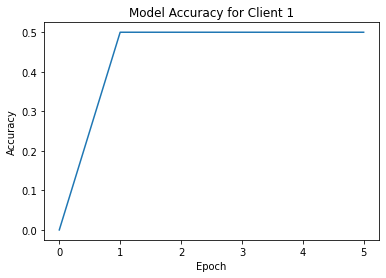

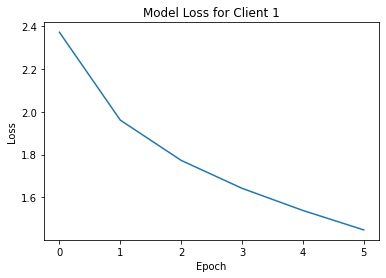

In [ ]:
print('========== Train on Local Device of Client 1 ==========')

history_accuracy_1 = []
history_loss_1 = []

for round_num in range(round_numbers):
    train_state, train_metrics = trainer.next(train_state, fed_client_1)
    history_accuracy_1.append(train_metrics['train']['categorical_accuracy'])
    history_loss_1.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics['train']))

plt.title('Model Accuracy for Client 1')
plt.plot(history_accuracy_1, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 1')
plt.plot(history_loss_1, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 2 ==========
round  0, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 3.1280894)])
round  1, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.6061997)])
round  2, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 2.1398807)])
round  3, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.9632204)])
round  4, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.7950383)])
round  5, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.6913986)])


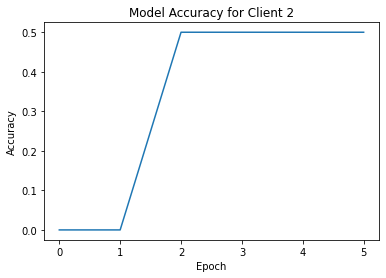

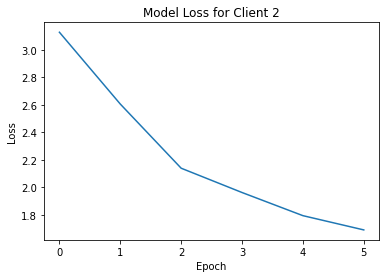

In [ ]:
print('========== Train on Local Device of Client 2 ==========')

history_accuracy_2 = []
history_loss_2 = []

for round_num in range(round_numbers):
    train_state, train_metrics = trainer.next(train_state, fed_client_2)
    history_accuracy_2.append(train_metrics['train']['categorical_accuracy'])
    history_loss_2.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics['train']))

plt.title('Model Accuracy for Client 2')
plt.plot(history_accuracy_2, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 2')
plt.plot(history_loss_2, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 3 ==========
round  0, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.544596)])
round  1, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.1693797)])
round  2, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.0278552)])
round  3, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.8804878)])
round  4, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.7261584)])
round  5, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 1.6140747)])


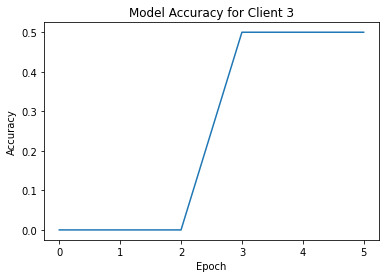

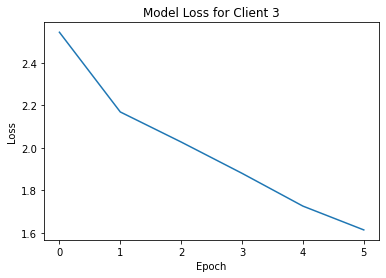

In [ ]:
print('========== Train on Local Device of Client 3 ==========')

history_accuracy_3 = []
history_loss_3 = []

for round_num in range(round_numbers):
    train_state, train_metrics = trainer.next(train_state, fed_client_3)
    history_accuracy_3.append(train_metrics['train']['categorical_accuracy'])
    history_loss_3.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics['train']))

plt.title('Model Accuracy for Client 3')
plt.plot(history_accuracy_3, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 3')
plt.plot(history_loss_3, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 4 ==========
round  0, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 3.1723795)])
round  1, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.9528615)])
round  2, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.6609535)])
round  3, metrics=OrderedDict([('categorical_accuracy', 0.0), ('loss', 2.2614975)])
round  4, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 2.1190255)])
round  5, metrics=OrderedDict([('categorical_accuracy', 0.5), ('loss', 2.0040152)])


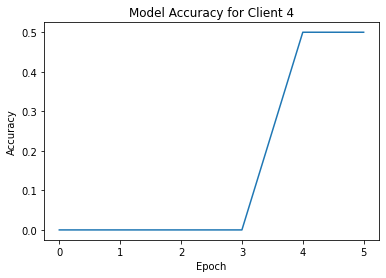

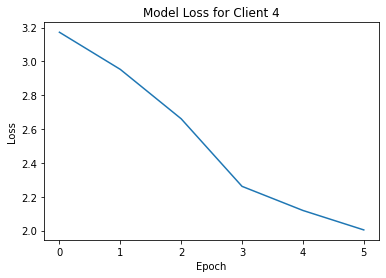

In [ ]:
print('========== Train on Local Device of Client 4 ==========')

history_accuracy_4 = []
history_loss_4 = []

for round_num in range(round_numbers):
    train_state, train_metrics = trainer.next(train_state, fed_client_4)
    history_accuracy_4.append(train_metrics['train']['categorical_accuracy'])
    history_loss_4.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics['train']))

plt.title('Model Accuracy for Client 4')
plt.plot(history_accuracy_4, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 4')
plt.plot(history_loss_4, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Evaluate the Model

In [ ]:
evaluator = tff.learning.build_federated_evaluation(create_federated_model)

In [ ]:
test_metrics = evaluator(train_state.model, fed_test)
print(test_metrics)